In [9]:
import os.path
import numpy as np

basePath = os.path.abspath("")
dataDirectory = os.path.join(basePath, "data")
inputDirectory = os.path.join(dataDirectory, "raw")

# check if data directory exists
if not os.path.exists(inputDirectory):
    print("Data directory does not exist. Please download the data and extract it to the data/raw directory. For more information, please see the data/README.md file.")
    exit(1)

all_file_names = sorted([
  os.path.join(root, file) for root, dirs, files in os.walk(inputDirectory) for file in files if file.lower().endswith(".csv")
])

len(all_file_names)

1178

In [10]:
def map_operation_phase(phase):
    modes = {
        7: "Anheizen",
        8: "Automatik",
        16: "Ausbrennen",
        13: "Ausgeschaltet",
        3: "Vorbelüften",
        14: "Zündung bereit",
        5: "Anzünden"
    }

    return modes[phase]

In [11]:
import csv
from datetime import datetime

def load_row(row):
    date_string = row[0] + " " + row[1]
    date = datetime.strptime(date_string, "%d.%m.%Y %H:%M:%S")

    converted_row = [value.replace(",", ".") for value in row[2:56]]
    converted_row = [date] + [float(value) if value != "" else None for value in converted_row]

    return {
        'date': date,
        'outsideTemperature': converted_row[1],  # outside temperature
        'refuellingQuantity': converted_row[3],  # Refuelling quantity
        'refuellingTimePoint': converted_row[4],  # Refuelling time point
        'prematureRefuellingCount': converted_row[5],  # Premature Refuelling Count
        'operationPhase': map_operation_phase(int(converted_row[8])),  # Operating phase
        'operationPhaseNumeric': int(converted_row[8]),  # Operating phase numeric
        'residualOxygen': converted_row[22],  # Residual oxygen value actual[ %]
        'flueGasTemperature': converted_row[28],  # Flue gas temperature actual [°C]
        'bufferTemperatureTop': converted_row[45],  # AC1 Temperature top actual
        'bufferTemperatureMiddleTop': converted_row[46],  # AC1 Temperature top-middle actual
        'bufferTemperatureMiddle': converted_row[47],  # AC1 Temperature middle actual
        'bufferTemperatureMiddleBottom': converted_row[48],  # AC1 Temperature middle-bottom actual
        'bufferTemperatureBottom': converted_row[49],  # AC1 Temperature bottom actual,
        'bufferChargingDegree': converted_row[50],  # AC1 Charging degree,
        'bufferUsableEnergyMax': converted_row[51],  # AC1 Usable energy max,
        'bufferUsableEnergyActual': converted_row[52],  # AC1 Usable energy actual
    }

def load_data(file):
    with open(file, 'r') as csv_file:
        reader = csv.reader(csv_file, delimiter=';')
        next(reader)  # skip header
        return [load_row(row) for row in reader]

Jetzt werde alle CSV Dateien eingelesen. Dies kann einige Minuten dauern. Damit man sieht, dass auch tatsächlich was passiert und wie lange man noch warten muss, wird `tqdm` verwendet. Dies ist eine Library um den Fortschritt nutzerfreundlich anzuzeigen.

In [12]:
from tqdm import tqdm
from joblib import Parallel, delayed

progress_bar = tqdm(all_file_names, desc="Loading data")
rows = Parallel(n_jobs=8)(delayed(load_data)(file) for file in progress_bar)

Loading data: 100%|██████████| 1178/1178 [00:34<00:00, 34.42it/s]


In [13]:
# flatten list
min_date = datetime(2019, 11, 12, 15, 55, 10)

rows = [row for file in tqdm(rows, desc="Flatten Days") for row in file if row['date'] >= min_date]

Flatten Days: 100%|██████████| 1178/1178 [00:02<00:00, 401.11it/s]


# Zielgröße ermitteln

In [14]:
def find_next_ignition(index):
    current_entry = rows[index]

    # Wenn "Ausgeschaltet", dann suche nach dem nächsten Anzünden, dazwischen darf kein anderer Zustand sein
    if current_entry['operationPhase'] == 'Ausgeschaltet' or current_entry['operationPhase'] == 'Ausbrennen':
        if current_entry['bufferChargingDegree'] <= 15:
            return None

        for next_index in range(index, len(rows)):
            next_entry = rows[next_index]
            if next_entry['bufferChargingDegree'] <= 15:
                return next_entry
            elif next_entry['operationPhase'] == 'Automatik':
                return None
        return None

    # Automatik, dann suche nach dem nächsten Anzünden, dazwischen darf kein anderer Zustand sein
    elif current_entry['operationPhase'] == 'Automatik':
        for next_index in range(index, len(rows)):
            next_entry = rows[next_index]
            if next_entry['operationPhase'] == 'Ausgeschaltet':
                ignition = find_next_ignition(next_index)
                return ignition
            elif next_entry['operationPhase'] != 'Automatik' and next_entry['operationPhase'] != 'Ausbrennen':
                return None
        return None

    # Zündung bereit, dann suche nach dem nächsten Anzünden, dazwischen darf kein anderer Zustand sein
    elif current_entry['operationPhase'] == 'Zündung bereit':
        for next_index in range(index, len(rows)):
            next_entry = rows[next_index]
            if next_entry['operationPhase'] == 'Automatik':
                ignition = find_next_ignition(next_index)
                return ignition
        return None

    # Ignore other states
    return None

In [15]:
last_ignition_check_state = None
last_ignition = None

for rowIndex, row in enumerate(tqdm(rows, desc="Generating extra fields")):
    if last_ignition is not None and (last_ignition['date'] <= row['date'] or last_ignition_check_state != row['operationPhase']):
        last_ignition = None
        last_ignition_check_state = None

    next_ignition = None
    if last_ignition is not None:
        next_ignition = last_ignition
    else:
        if last_ignition_check_state != row['operationPhase']:
            last_ignition_check_state = row['operationPhase']
            next_ignition = find_next_ignition(rowIndex)
            last_ignition = next_ignition

    if next_ignition is not None:
        row['refuellingDateActual'] = next_ignition['date']
        row['refuellingChargingDegreeActual'] = next_ignition['bufferChargingDegree']
    else:
        row['refuellingDateActual'] = None
        row['refuellingChargingDegreeActual'] = None

Generating extra fields: 100%|██████████| 10165925/10165925 [00:09<00:00, 1108365.26it/s]


In [16]:
import pandas as pd

df = pd.DataFrame(rows)

# Inspect and cleanup

In [17]:
df.shape

(10165925, 19)

In [18]:
df.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
date,10165925,2021-06-23 02:17:58.741598464,2019-11-12 15:55:14,2020-09-01 21:53:20,2021-06-23 02:28:40,2022-04-13 06:23:00,2023-02-01 16:02:12,NaN
outsideTemperature,10165925.0,12.039188,-7.5,7.5,11.6,16.3,32.6,5.802519
refuellingQuantity,10165925.0,25.951493,0.0,0.0,20.0,45.0,100.0,25.291949
refuellingTimePoint,10165925.0,2020.982092,0.0,436.0,872.0,1726.0,65535.0,3930.891469
prematureRefuellingCount,10165925.0,522.101913,0.0,225.0,548.0,870.0,1064.0,291.400751
operationPhaseNumeric,10165925.0,11.815645,3.0,8.0,13.0,13.0,16.0,2.552581
residualOxygen,10165925.0,2.203847,0.0,0.0,0.0,5.1,21.0,4.105319
flueGasTemperature,10165925.0,79.589997,0.0,41.0,52.0,140.0,254.0,54.985525
bufferTemperatureTop,10165925.0,72.769116,0.0,69.0,76.0,79.0,92.0,9.101925
bufferTemperatureMiddleTop,10165925.0,65.7673,0.0,56.0,72.0,78.0,91.0,15.943329


Auffallend ist der hohe Maximalwert der Spalte `refuellingTimePoint` von $65535 = 2^{16} - 1$. Dieser Wert ist ein status Wert und kein echter Messwert und wird mit `nan` ersetzt. Zuvor wird noch geprüft, ob es weitere solcher Werte gibt.

In [19]:
df['refuellingTimePoint'].value_counts().sort_index(ascending=False).head()

refuellingTimePoint
65535.0    9429
17476.0    1180
17475.0    4286
17474.0    4158
17473.0    4054
Name: count, dtype: int64

In [20]:
# replace 65535 with nan
df['refuellingTimePoint'] = df['refuellingTimePoint'].replace(65535, np.nan)
df.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
date,10165925,2021-06-23 02:17:58.741598464,2019-11-12 15:55:14,2020-09-01 21:53:20,2021-06-23 02:28:40,2022-04-13 06:23:00,2023-02-01 16:02:12,NaN
outsideTemperature,10165925.0,12.039188,-7.5,7.5,11.6,16.3,32.6,5.802519
refuellingQuantity,10165925.0,25.951493,0.0,0.0,20.0,45.0,100.0,25.291949
refuellingTimePoint,10156496.0,1962.017497,0.0,436.0,871.0,1720.0,17476.0,3423.112225
prematureRefuellingCount,10165925.0,522.101913,0.0,225.0,548.0,870.0,1064.0,291.400751
operationPhaseNumeric,10165925.0,11.815645,3.0,8.0,13.0,13.0,16.0,2.552581
residualOxygen,10165925.0,2.203847,0.0,0.0,0.0,5.1,21.0,4.105319
flueGasTemperature,10165925.0,79.589997,0.0,41.0,52.0,140.0,254.0,54.985525
bufferTemperatureTop,10165925.0,72.769116,0.0,69.0,76.0,79.0,92.0,9.101925
bufferTemperatureMiddleTop,10165925.0,65.7673,0.0,56.0,72.0,78.0,91.0,15.943329


# Wetter Daten

Da Heizen sehr stark durch das Wetter beeinflusst wird, werden historische Wetterdaten mit in das Modell einbezogen.
Dazu werden die Daten zunächst geladen und anschließend dem Datensatz zugeführt.

Die Wetterdaten werden von [Meteostat](https://meteostat.net/en/) bezogen, einer kostenlosen Open-Source Quelle für freie Wetterdaten.
Praktischerweise gibt es ein Python Package, um diese zu laden.

In [21]:
from datetime import datetime
from meteostat import Point, Hourly

# Set time period
start = datetime(2019, 11, 1)
end = datetime(2023, 2, 5)

location = Point(54.285441, 9.620360)

# Get daily data for 2018
hourly = Hourly(location, start, end)
weather_df = hourly.fetch()

In [22]:
weather_df.head()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2019-11-01 00:00:00,-2.7,-3.2,96.0,0.0,NaN,120.0,7.0,11.1,1022.0,0.0,1.0
2019-11-01 01:00:00,-2.3,-3.0,95.0,0.0,NaN,120.0,4.0,13.0,1021.1,0.0,2.0
2019-11-01 02:00:00,-2.1,-2.7,96.0,0.0,NaN,120.0,7.0,13.0,1020.1,0.0,2.0
2019-11-01 03:00:00,-2.6,-3.1,96.0,0.0,NaN,130.0,7.0,14.8,1019.1,0.0,1.0
2019-11-01 04:00:00,-2.0,-2.7,95.0,0.0,NaN,110.0,7.0,18.5,1018.0,0.0,2.0


## Daten auswählen

Nicht alle Daten werden für das Modell benötigt. Daher werden nur die Spalten ausgewählt, die für das Modell relevant sind.

In [23]:
weather_df = weather_df[['temp', 'wspd', 'wdir']]
weather_df.rename(columns={'temp': 'weatherTemperature'}, inplace=True)

# Feature engineering

Nicht alle Daten sind in der Form in der sie vorliegen geeignet für das Modell. Daher werden einige Spalten umgewandelt oder neue Spalten aus bestehenden Spalten generiert.

# Zeit bis zum nächsten Auffüllen

Aus den Rohdaten konnte der nächste Nachfüllzeitpunkt ermittelt werden. Dieser wird nun in eine Spalte umgewandelt, die die Zeit bis zum nächsten Auffüllen in Stunden angibt.
Außerdem wird die Spalte `refuellingTimePoint` von Minuten in Stunden umgewandelt.

In [24]:
df['refuellingTimePointActual'] = (df['refuellingDateActual'] - df['date']).dt.total_seconds() / 60 / 60
df['refuellingTimePoint'] = df['refuellingTimePoint'] / 60

## Wind

Die Winddaten liegen als Windgeschwindigkeit und Windrichtung vor. Dies ist ungeeignet, da die Windrichtung als Winkel vorliegt im Bereich von 0 bis 360 Grad. Dies ist nicht sinnvoll, da 0 Grad und 360 Grad die gleiche Richtung sind. Daher wird die Windrichtung in zwei Spalten umgewandelt, die die x und y Komponente des Windes darstellen.

Zunächst werden die Daten geplottet, um zu sehen, wie die Werte aktuell verteilt sind.

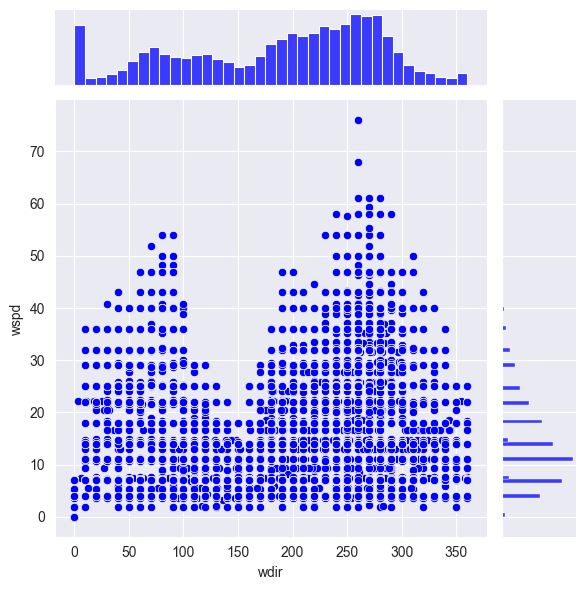

In [25]:
import seaborn as sns
sns.jointplot(x=weather_df['wdir'], y=weather_df['wspd'], color='blue')

In [26]:
wv = weather_df.pop('wspd')
wd_rad = weather_df.pop('wdir') * np.pi / 180

# Calculate the wind x and y components.
weather_df['weatherWindX'] = wv * np.cos(wd_rad)
weather_df['weatherWindY'] = wv * np.sin(wd_rad)

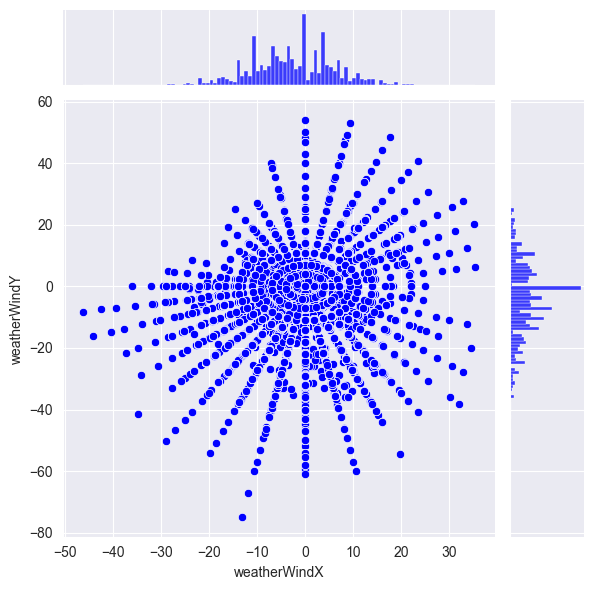

In [27]:
# plot the wind vector
sns.jointplot(x=weather_df['weatherWindX'], y=weather_df['weatherWindY'], color='blue')

## Wettervorhersage

Um den Nachfüllzeitpunkt vorherzusagen ist die Wettervorhersage vermutlich relevant. Daher werden die Wetterdaten um die Wettervorhersage erweitert. Dazu werden die Wetterdaten um 6, 12, 18 und 24 Stunden verschoben und die Spalten entsprechend ergänzt.

In [28]:
# merge weather data with itself shifted by 6 hours

weather_df = weather_df \
    .join(weather_df.shift(-6), rsuffix='_6') \
    .join(weather_df.shift(-12), rsuffix='_12') \
    .join(weather_df.shift(-18), rsuffix='_18') \
    .join(weather_df.shift(-24), rsuffix='_24')

In [29]:
# delete columns with NaN values
weather_df = weather_df.dropna()

## Datum & Zeit

In [30]:
timestamps = df['date'].map(pd.Timestamp.timestamp)

day = 24*60*60
year = 365.2425 * day

df['Year sin'] = np.sin(timestamps * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamps * (2 * np.pi / year))

Zuletzt können die Spalten geplottet werden, um zu sehen, ob die Werte sinnvoll sind.

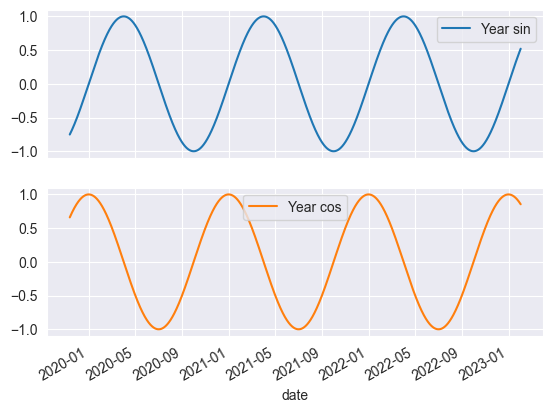

In [31]:
plot_cols = ['Year sin', 'Year cos']
plot_features = df[plot_cols]
plot_features.index = df['date']
_ = plot_features.plot(subplots=True)

# One-Hot Encoding für Betriebsphase

In [32]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
encoder.fit(df[['operationPhase']])
encoded = encoder.transform(df[['operationPhase']])
encoded_df = pd.DataFrame(encoded, columns=encoder.categories_[0])

df = df.merge(encoded_df, left_index=True, right_index=True)

# Daten zusammenführen

Zuletzt können die beiden Datensätze zusammengeführt werden.

In [33]:
# Merge weather data
df['weather_date'] = df['date'].dt.floor('H')
df = df.merge(weather_df, left_on='weather_date', right_on='time', how='left')
df.drop(columns=['weather_date'], inplace=True)

In [34]:
df.head()

,date,outsideTemperature,refuellingQuantity,refuellingTimePoint,prematureRefuellingCount,operationPhase,operationPhaseNumeric,residualOxygen,flueGasTemperature,bufferTemperatureTop,...,weatherWindY_6,weatherTemperature_12,weatherWindX_12,weatherWindY_12,weatherTemperature_18,weatherWindX_18,weatherWindY_18,weatherTemperature_24,weatherWindX_24,weatherWindY_24
0,2019-11-12 15:55:14,8.0,30.0,13.066667,0.0,Ausgeschaltet,13,0.0,57.0,78.0,...,8.572528e-16,1.4,-7.070664,8.426489,3.0,-13.155697,4.788282,5.6,-13.787309,-2.431074
1,2019-11-12 15:55:24,8.0,30.0,13.066667,0.0,Ausgeschaltet,13,0.0,57.0,78.0,...,8.572528e-16,1.4,-7.070664,8.426489,3.0,-13.155697,4.788282,5.6,-13.787309,-2.431074
2,2019-11-12 15:55:34,8.0,30.0,13.066667,0.0,Ausgeschaltet,13,0.0,57.0,78.0,...,8.572528e-16,1.4,-7.070664,8.426489,3.0,-13.155697,4.788282,5.6,-13.787309,-2.431074
3,2019-11-12 15:55:44,8.0,30.0,13.066667,0.0,Ausgeschaltet,13,0.0,57.0,78.0,...,8.572528e-16,1.4,-7.070664,8.426489,3.0,-13.155697,4.788282,5.6,-13.787309,-2.431074
4,2019-11-12 15:55:54,8.0,30.0,13.066667,0.0,Ausgeschaltet,13,0.0,57.0,78.0,...,8.572528e-16,1.4,-7.070664,8.426489,3.0,-13.155697,4.788282,5.6,-13.787309,-2.431074


In [35]:
df.columns

Index(['date', 'outsideTemperature', 'refuellingQuantity',
       'refuellingTimePoint', 'prematureRefuellingCount', 'operationPhase',
       'operationPhaseNumeric', 'residualOxygen', 'flueGasTemperature',
       'bufferTemperatureTop', 'bufferTemperatureMiddleTop',
       'bufferTemperatureMiddle', 'bufferTemperatureMiddleBottom',
       'bufferTemperatureBottom', 'bufferChargingDegree',
       'bufferUsableEnergyMax', 'bufferUsableEnergyActual',
       'refuellingDateActual', 'refuellingChargingDegreeActual',
       'refuellingTimePointActual', 'Year sin', 'Year cos', 'Anheizen',
       'Anzünden', 'Ausbrennen', 'Ausgeschaltet', 'Automatik', 'Vorbelüften',
       'Zündung bereit', 'weatherTemperature', 'weatherWindX', 'weatherWindY',
       'weatherTemperature_6', 'weatherWindX_6', 'weatherWindY_6',
       'weatherTemperature_12', 'weatherWindX_12', 'weatherWindY_12',
       'weatherTemperature_18', 'weatherWindX_18', 'weatherWindY_18',
       'weatherTemperature_24', 'weatherWindX_

In [36]:
# save data to file
df.to_csv(os.path.join(dataDirectory, 'merged.csv'), index=False)